In [1]:
import networkx as nx
import osmnx as ox

import pandas as pd
import numpy as np
import geopandas as gpd

In [2]:
df = pd.read_csv("geo_locations_astana_hackathon")

In [3]:
df.head()

,randomized_id,lat,lng,alt,spd,azm
0,7637058049336049989,51.095460,71.427530,350.531020,0.206810,13.601680
1,1259981924615926140,51.098200,71.412950,348.801610,0.000000,265.677000
2,1259981924615926140,51.098460,71.412120,349.273880,4.345010,307.245300
3,7180852955221959108,51.089779,71.428469,314.000000,14.326102,192.123672
4,-6683155579225977143,51.088782,71.417462,325.300018,0.000602,0.000000


In [4]:
df.loc[df['spd'] < 0, 'spd'] = 0
df['spd'] = df['spd'] * 3.6

In [5]:
G = ox.graph_from_place("Astana, Kazakhstan", network_type="drive")
G_proj = ox.project_graph(G)

In [6]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lng, df.lat),
    crs="EPSG:4326" # This is the WGS 84 CRS
)

In [7]:
gdf_proj = gdf.to_crs(G_proj.graph['crs'])

In [8]:
nearest_edges, dists = ox.nearest_edges(
    G_proj,
    X=gdf_proj.geometry.x.values,
    Y=gdf_proj.geometry.y.values,
    return_dist=True
)

In [9]:
df['distance_to_edge'] = dists
df['belongs_to'] = nearest_edges

In [10]:
df['edge_u'], df['edge_v'], df['edge_key'] = zip(*nearest_edges)

In [11]:
# Define your distance threshold in meters
threshold = 10  # meters

# Keep only the rows where the distance is within the threshold
matched_df = df[df['distance_to_edge'] < threshold].copy()

print(f"\nOriginal points: {len(df)}")
print(f"Points after matching (within {threshold}m): {len(matched_df)}")


Original points: 1262687
Points after matching (within 10m): 971613


In [12]:
matched_df.head()

,randomized_id,lat,lng,alt,spd,azm,distance_to_edge,belongs_to,edge_u,edge_v,edge_key
0,7637058049336049989,51.095460,71.427530,350.53102,0.744516,13.601680,4.987784,"(2506348929, 1773372182, 0)",2506348929,1773372182,0
3,7180852955221959108,51.089779,71.428469,314.00000,51.573968,192.123672,2.603571,"(5700289568, 6512858541, 0)",5700289568,6512858541,0
5,-9163058962347897266,51.094540,71.407610,349.61183,14.464008,170.381230,1.481828,"(4985151127, 5306138640, 0)",4985151127,5306138640,0
6,5965568696283616614,51.098690,71.405960,351.53058,40.189176,247.881290,5.166092,"(1773388183, 2616721092, 0)",1773388183,2616721092,0
7,5965568696283616614,51.100380,71.406630,350.85470,46.202580,216.541870,0.723799,"(2616721091, 5070894912, 0)",2616721091,5070894912,0


In [13]:
# points_count_on_edges = matched_df.groupby('belongs_to').agg(
#     randomized_id_count=('randomized_id', 'count')
# ).sort_values(by='randomized_id_count', ascending=False)
points_count_on_edges = (
    matched_df
    .groupby('belongs_to')
    .agg(randomized_id_count=('randomized_id', 'nunique'))
    .sort_values(by='randomized_id_count', ascending=False)
)


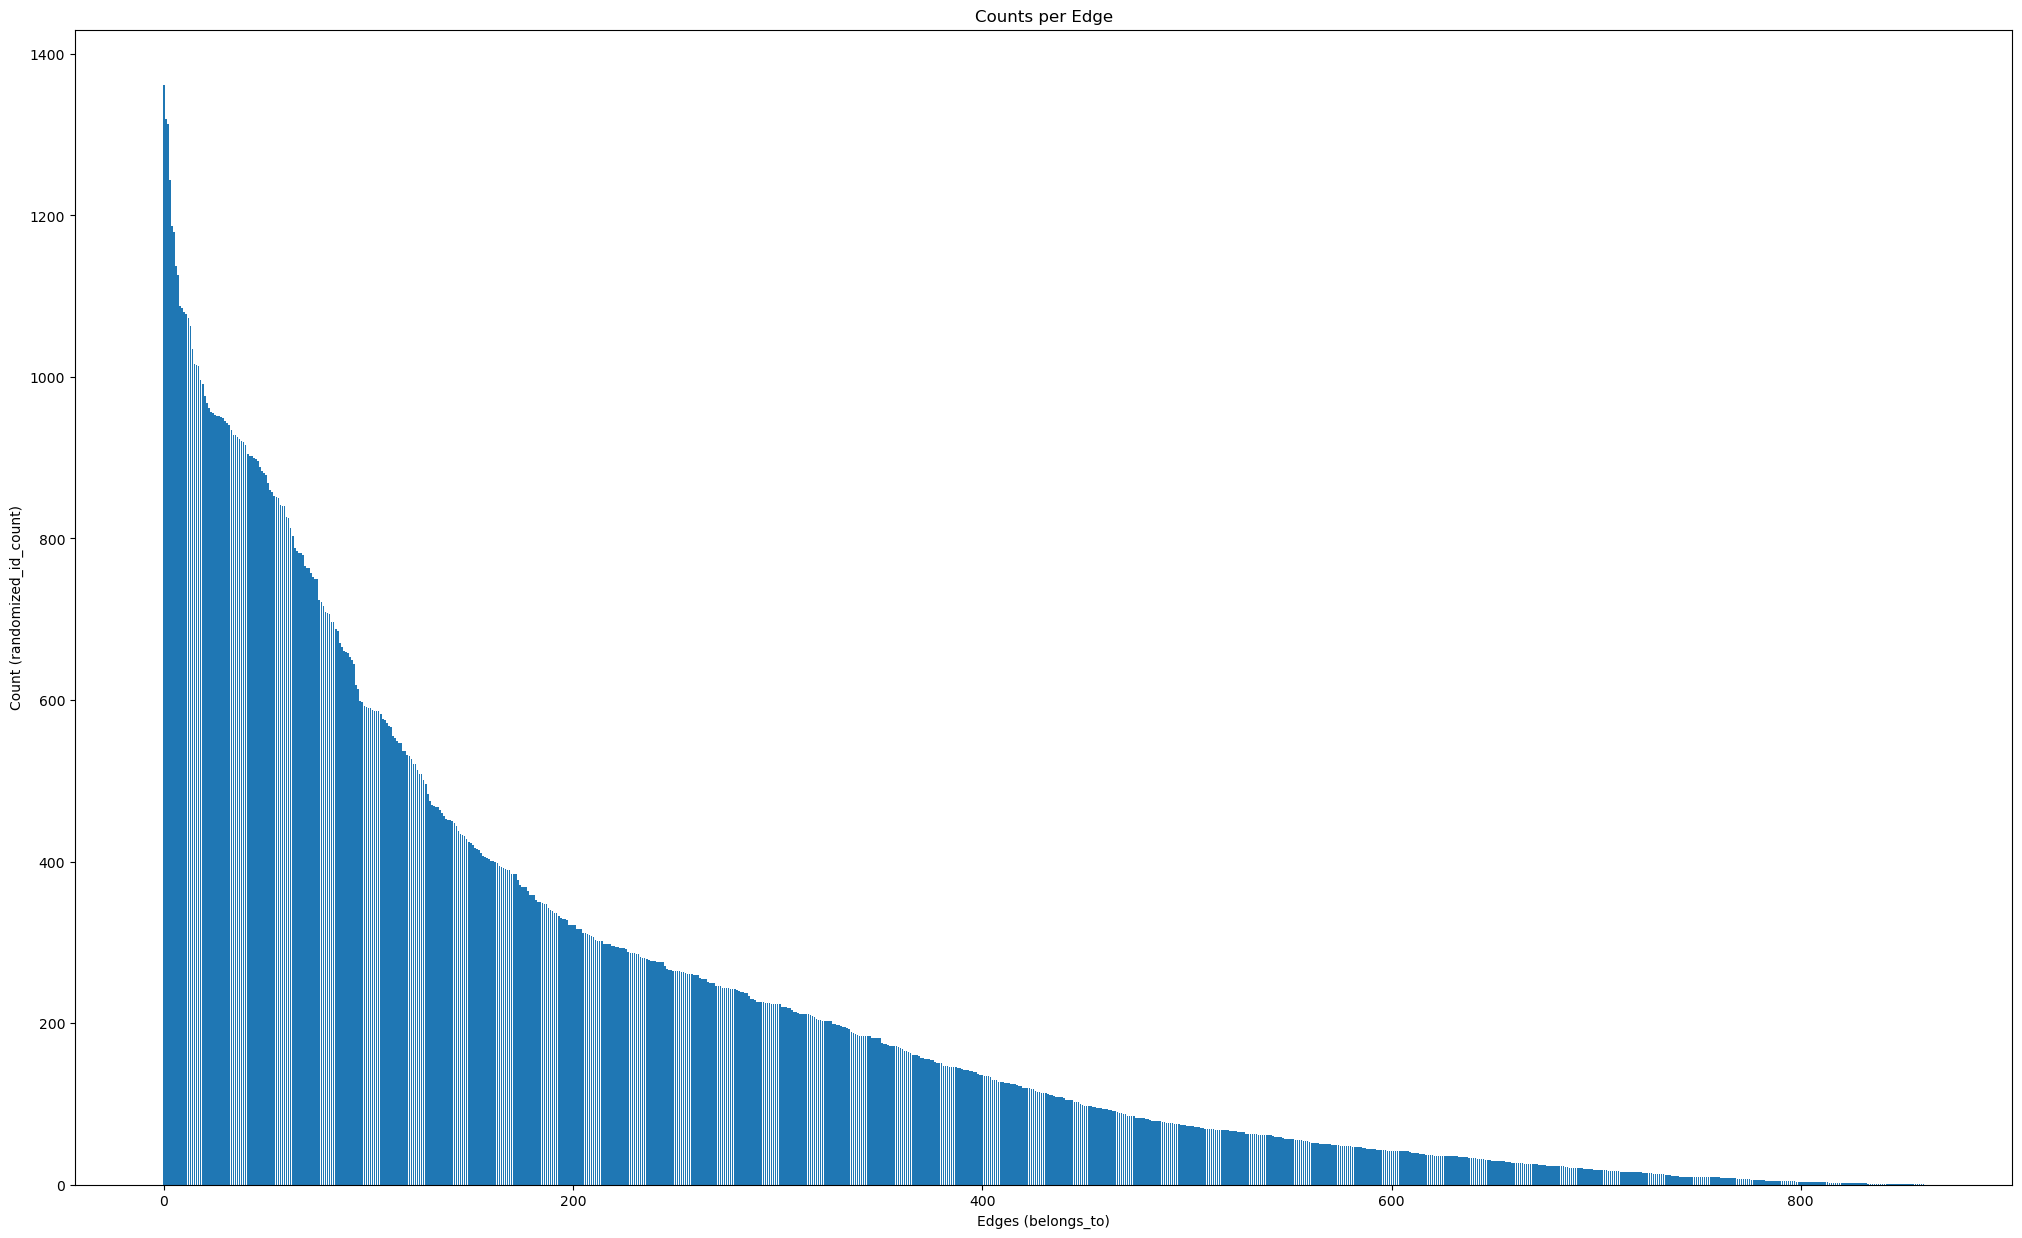

In [75]:
import matplotlib.pyplot as plt

# Sort values so the biggest counts are on top
df_sorted = points_count_on_edges.sort_values("randomized_id_count", ascending=False)

plt.figure(figsize=(25,15))
plt.bar(range(len(df_sorted)), df_sorted["randomized_id_count"])
plt.xlabel("Edges (belongs_to)")
plt.ylabel("Count (randomized_id_count)")
plt.title("Counts per Edge")

# Optional: rotate x-axis labels if you want to show belongs_to values
# plt.xticks(range(len(df_sorted)), df_sorted.index, rotation=90)
plt.savefig('edges_histogram.png')
plt.show()


# Congestion calculation

If in the edge they are a lot of cars that are moving slow -> congestion. Cars - unique_randomized_id

In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale # Using a standard library is often best practice

def compute_edge_stats(
    matched_df: pd.DataFrame, 
    slow_speed_thresh: float = 10.0,
    dedupe_vehicle_pings: bool = False
) -> pd.DataFrame:
    """
    Computes and returns a DataFrame indexed by 'belongs_to' with key edge-level statistics.

    Args:
        matched_df: DataFrame with at least ['belongs_to', 'randomized_id', 'spd'].
        slow_speed_thresh: Speed below which a point is considered 'slow'.
        dedupe_vehicle_pings: If True, considers only the first ping from each vehicle on an edge.
                              This is useful if you want to count unique vehicles without multiple pings
                              from the same vehicle biasing other stats like mean speed.
    """
    df = matched_df.copy()
    df['spd'] = pd.to_numeric(df['spd'], errors='coerce')
    df = df.dropna(subset=['spd']) # Drop rows where speed is not a valid number

    if dedupe_vehicle_pings:
        # Keep only the first observation for each vehicle on each edge
        df = df.drop_duplicates(subset=['belongs_to', 'randomized_id'])

    # Perform all aggregations in a single, efficient operation
    edge_stats = df.groupby('belongs_to').agg(
        point_count=('spd', 'size'), # 'size' is faster than 'count' for non-null data
        unique_vehicles=('randomized_id', 'nunique'),
        mean_speed=('spd', 'mean'),
        median_speed=('spd', 'median'),
        speed_std=('spd', 'std'),
        # Calculate percentage of slow points directly and name the column
        pct_slow=('spd', lambda s: (s < slow_speed_thresh).mean())
    ).fillna(0) # Fill any resulting NaNs (e.g., std for a single point) with 0

    return edge_stats

def calculate_congestion_score(
    edge_stats: pd.DataFrame, 
    w_volume: float = 0.1, 
    w_slow: float = 0.9,
    w_speed: float = 0.0
) -> pd.Series:
    """
    Calculates a composite congestion score based on edge statistics.

    Args:
        edge_stats: DataFrame from compute_edge_stats.
        w_volume: Weight for the vehicle volume component.
        w_slow: Weight for the percentage of slow vehicles component.
        w_speed: Weight for the speed reduction component.
    """
    # 1. Volume Component: Log-transform to dampen effect of extreme outliers, then scale
    # Using 'unique_vehicles' is often more robust than 'point_count'
    scaled_volume = minmax_scale(np.log1p(edge_stats['unique_vehicles']))
    
    # 2. Slowness Component: This is already a percentage (0-1)
    pct_slow = edge_stats['pct_slow'].values

    # 3. Speed Reduction Component: Scaled median speed is more robust to outliers
    # We use (1 - speed) because lower speed means higher congestion
    scaled_speed_reduction = 1.0 - minmax_scale(edge_stats['median_speed'])

    # Combine into a weighted average
    raw_score = (
        w_volume * scaled_volume +
        w_slow * pct_slow +
        w_speed * scaled_speed_reduction
    )
    
    return pd.Series(raw_score, index=edge_stats.index, name='congestion_score')


def derive_congestion_for_edges(
    matched_df: pd.DataFrame,
    slow_speed_thresh: float = 12.0,
    composite_weights: tuple = (0.3, 0.5, 0.2)
) -> pd.DataFrame:
    """
    Top-level function to derive edge statistics and a composite congestion score.
    """
    stats = compute_edge_stats(matched_df, slow_speed_thresh=slow_speed_thresh)
    
    congestion_score = calculate_congestion_score(
        stats,
        w_volume=composite_weights[0],
        w_slow=composite_weights[1],
        w_speed=composite_weights[2]
    )
    
    # Join the score back to the stats DataFrame
    return stats.join(congestion_score)

# --- Example Usage ---
# Assuming 'matched_df' is your DataFrame
# edges = derive_congestion_for_edges(matched_df, slow_speed_thresh=12.0)
# print(edges.sort_values('congestion_score', ascending=False).head(10))

In [70]:
edges = derive_congestion_for_edges(matched_df, slow_speed_thresh=12.0, composite_weights=(0.55,0,0.45))
edges.sort_values('congestion_score', ascending=False).head(10)

,point_count,unique_vehicles,mean_speed,median_speed,speed_std,pct_slow,congestion_score
belongs_to,,,,,,,
"(1773388179, 2616721090, 0)",6180,926,15.121571,13.238272,14.422567,0.479450,0.868858
"(4980849124, 4906135655, 0)",2830,277,8.216206,0.575692,11.589605,0.714488,0.861688
"(6878481988, 3311859778, 0)",4729,750,14.800973,12.220610,14.408098,0.494819,0.858692
"(4527656778, 4794856833, 0)",5091,467,13.278039,7.411479,14.532604,0.563936,0.854658
"(4794856831, 5761119638, 0)",1864,384,17.867739,6.207054,19.526310,0.525215,0.847176
"(9879297310, 3513966418, 0)",1074,411,12.726444,7.250188,14.071904,0.575419,0.845116
"(2506348935, 1773372179, 0)",5670,1085,18.999312,18.324096,16.503607,0.392240,0.844306
"(6878559757, 4015017018, 0)",3099,764,16.692284,14.629115,15.564713,0.448209,0.842302
"(5761119638, 4794856831, 0)",704,198,13.111258,0.011797,18.743713,0.659091,0.837707


In [71]:
edges.point_count.sum(), matched_df.shape[0]

(np.int64(971613), 971613)

In [72]:
matched_df.head()

,randomized_id,lat,lng,alt,spd,azm,distance_to_edge,belongs_to,edge_u,edge_v,edge_key
0,7637058049336049989,51.095460,71.427530,350.53102,0.744516,13.601680,4.987784,"(2506348929, 1773372182, 0)",2506348929,1773372182,0
3,7180852955221959108,51.089779,71.428469,314.00000,51.573968,192.123672,2.603571,"(5700289568, 6512858541, 0)",5700289568,6512858541,0
5,-9163058962347897266,51.094540,71.407610,349.61183,14.464008,170.381230,1.481828,"(4985151127, 5306138640, 0)",4985151127,5306138640,0
6,5965568696283616614,51.098690,71.405960,351.53058,40.189176,247.881290,5.166092,"(1773388183, 2616721092, 0)",1773388183,2616721092,0
7,5965568696283616614,51.100380,71.406630,350.85470,46.202580,216.541870,0.723799,"(2616721091, 5070894912, 0)",2616721091,5070894912,0


In [73]:
north = df['lat'].max()
south = df['lat'].min()
east = df['lng'].max()
west = df['lng'].min()
bbox = (west, south, east, north)
G = ox.graph_from_bbox(bbox, network_type="drive")
G_proj = ox.project_graph(G)

/tmp/ipykernel_26265/1376592754.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


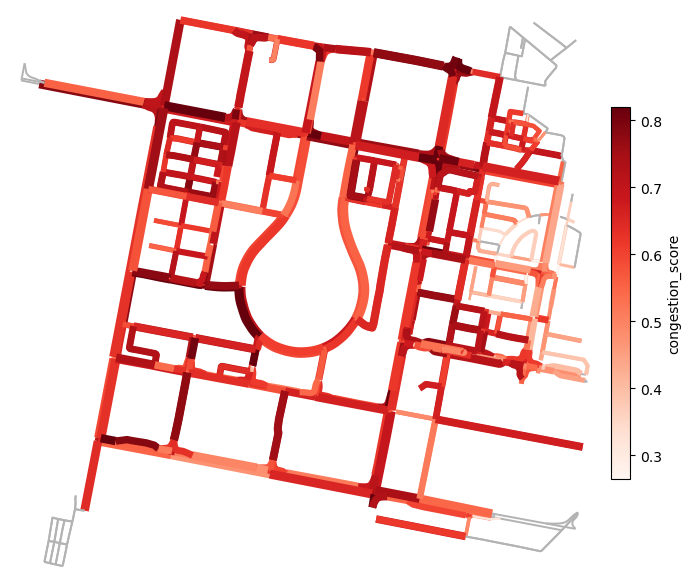

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import osmnx as ox

# G_proj is your projected graph and `edges` is your DataFrame with index 'belongs_to'
# make sure edges is a dataframe with columns ['belongs_to','congestion_score','point_count'] (point_count optional)
edges = edges.reset_index()  # if needed
cong_dict = dict(zip(edges['belongs_to'], edges['congestion_score']))
# if you also want linewidth scaling:
pc_dict = dict(zip(edges['belongs_to'], edges.get('point_count', np.ones(len(edges)))))

scores = []
edge_linewidths = []
# collect scores in the same order as graph edges iteration
for u, v, k, data in G_proj.edges(keys=True, data=True):
    # try exact orientation, then reversed orientation (if your DF used the opposite direction)
    score = cong_dict.get((u, v, k))
    if score is None:
        score = cong_dict.get((v, u, k))  # try reverse
    # fallback (if still None) -> np.nan (we'll color these gray)
    if score is None:
        scores.append(np.nan)
    else:
        scores.append(float(score))
    # optional linewidth by point_count (comment out if not needed)
    pc = pc_dict.get((u, v, k)) or pc_dict.get((v, u, k)) or 1
    edge_linewidths.append(1.0 + np.log1p(pc) * 0.6)  # example scaling

scores_arr = np.array(scores, dtype=float)

# Decide vmin/vmax (use percentiles to avoid extreme outliers dominating)
vmin = np.nanpercentile(scores_arr, 2)
vmax = np.nanpercentile(scores_arr, 98)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('Reds')

# create list of RGBA colors; missing scores -> light gray
edge_colors = [
    cmap(norm(s)) if not np.isnan(s) else (0.7, 0.7, 0.7, 1.0)
    for s in scores_arr
]

# Plot graph and keep figure/axes so we can add colorbar
fig, ax = ox.plot_graph(
    G_proj,
    edge_color=edge_colors,
    edge_linewidth=edge_linewidths,  # or use a single float like 1.2
    node_size=0,
    bgcolor='white',
    show=False,
    close=False
)

# create a ScalarMappable for the colorbar (use same cmap and norm)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(scores_arr)  # required for colorbar scale

cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label('congestion_score')

plt.show()
# if you prefer to save: fig.savefig('astana_congestion.png', dpi=300, bbox_inches='tight')
